# Word2Vec(CBOW)

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [3]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index

In [4]:
word_to_index

{'철수은': 1, '축구를': 2, '좋아한다': 3, '영희은': 4, '싫어한다': 5, '도서관을': 6, '공부를': 7}

In [5]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
print(index_to_word)

{1: '철수은', 2: '축구를', 3: '좋아한다', 4: '영희은', 5: '싫어한다', 6: '도서관을', 7: '공부를'}


In [6]:
cbow_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(1, len(sequence) - 1):
        target = sequence[i]
        context = [sequence[i - 1], sequence[i + 1]]
        cbow_data.append([target, context])
        
print(f'cbow_data\n{cbow_data}')

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
cbow_data
[[2, [1, 3]], [2, [4, 5]], [6, [1, 3]], [6, [4, 5]], [7, [1, 3]], [7, [4, 5]], [2, [1, 3]], [3, [2, 4]], [4, [3, 2]], [2, [4, 5]]]


In [8]:
context_left = []
context_right = []
target = []
for i in range(len(cbow_data)):
    context_left.append(cbow_data[i][1][0])  # input1
    context_right.append(cbow_data[i][1][1])  # input2
    target.append(cbow_data[i][0])  # label

In [9]:
num_epochs = 1000
batch_size = 2

In [68]:
def mapping_function(left_inputs, right_inputs, labels):
    features = {'left': left_inputs, 'right': right_inputs}
    
    return features, labels

In [83]:
dataset = tf.data.Dataset.from_tensor_slices((context_left, context_right, target))
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(len(cbow_data))
dataset = dataset.map(mapping_function)

In [97]:
vocab_size = len(word_to_index) + 1
emb_size = 128

In [98]:
from tensorflow.keras import layers

In [102]:
class CBOWModel(tf.keras.Model):
    
    def __init__(self, vocab_size, emb_size):
        super(CBOWModel, self).__init__(name='cbow')
        self.vocab_size = vocab_size
        self.w_1 = tf.Variable(tf.random.uniform([vocab_size, emb_size], -1.0, 1.0))
        self.w_2 = tf.Variable(tf.random.uniform([emb_size, vocab_size], -1.0, 1.0))
    
    def call(self, inputs):
        one_hot_left_inputs = tf.one_hot(indices=inputs['left'], depth=self.vocab_size)
        one_hot_right_inputs = tf.one_hot(indices=inputs['right'], depth=self.vocab_size)
        one_hot_left_inputs = tf.squeeze(one_hot_left_inputs, axis=1)
        one_hot_right_inputs = tf.squeeze(one_hot_right_inputs, axis=1)
        
        h_1 = tf.matmul(one_hot_left_inputs, self.w_1)
        h_2 = tf.matmul(one_hot_right_inputs, self.w_1)
        hidden = (h_1 + h_2) / 2
        
        return tf.matmul(hidden, self.w_2)

In [104]:
model = CBOWModel(vocab_size = vocab_size, emb_size=emb_size)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(dataset, epochs=num_epochs)

Epoch 1/100
5/5 [==============================] - 0s 82ms/step - loss: 230.2351 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 249.9519 - accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 192.7716 - accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 245.7170 - accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 245.5620 - accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 203.5479 - accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 245.3596 - accuracy: 0.0000e+00
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 248.2793 - accuracy: 0.0000e+00
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 191.6528 - accuracy: 0.0000e+00
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 

In [109]:
embedding_matrix = model.w_1.numpy()

In [110]:
embedding_matrix

array([[-0.9708998 ,  0.6570835 , -0.45693064, ...,  0.8140433 ,
         0.43642712, -0.06114078],
       [-0.31476718, -0.39372048, -0.5975746 , ..., -0.3960698 ,
        -0.7127108 , -0.8098971 ],
       [-0.95963395,  0.80812645,  0.8626077 , ..., -0.8325495 ,
         0.61127555, -0.40324655],
       ...,
       [-0.48174757,  0.506489  , -0.7973695 , ..., -0.95553863,
         0.75880694,  0.56994545],
       [ 0.42679644, -0.8408401 , -0.17859936, ..., -0.49732232,
        -0.1594503 , -0.6052067 ],
       [ 0.96453214, -0.9757905 ,  0.6391945 , ..., -0.7596133 ,
         0.23627067, -0.9073026 ]], dtype=float32)

### 임베딩 그림 그리기

In [111]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [112]:
from sklearn.manifold import TSNE

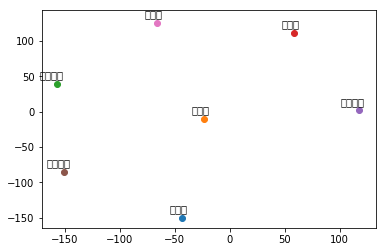

In [114]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embedding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [117]:
import matplotlib.font_manager as fm  

In [118]:
font_path = '/content/gdrive/My Drive/asset/font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

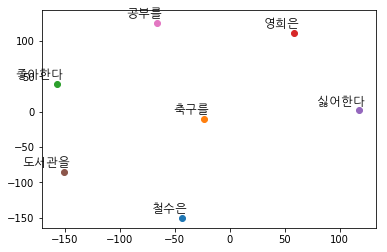

In [120]:
xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()